## Setup & Import Libraries

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## Load Data

Load hasil aggregasi dari `processed/train_processed.csv`.

In [21]:
# Load the aggregated data
train_merged = pd.read_csv('/content/processed/train_processed.csv')

print(f"Data shape: {train_merged.shape}")
print(f"\nTarget distribution:")
print(train_merged['TARGET'].value_counts())
print(f"\nTarget distribution (percentage):")
print(train_merged['TARGET'].value_counts(normalize=True))

train_merged.head()

Data shape: (307511, 149)

Target distribution:
TARGET
0    282686
1     24825
Name: count, dtype: int64

Target distribution (percentage):
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,BU_DAYS_CREDIT_mean,BU_DAYS_CREDIT_min,BU_DAYS_CREDIT_max,BU_AMT_CREDIT_SUM_sum,BU_AMT_CREDIT_SUM_mean,BU_AMT_CREDIT_SUM_max,BU_AMT_CREDIT_SUM_DEBT_sum,BU_AMT_CREDIT_SUM_DEBT_mean,BU_CREDIT_DAY_OVERDUE_sum,BU_CREDIT_DAY_OVERDUE_max,BU_CREDIT_ACTIVE_<lambda>,PA_AMT_CREDIT_mean,PA_AMT_CREDIT_max,PA_AMT_CREDIT_min,PA_AMT_CREDIT_sum,PA_AMT_ANNUITY_mean,PA_AMT_ANNUITY_max,PA_AMT_ANNUITY_min,PA_AMT_ANNUITY_sum,PA_AMT_GOODS_PRICE_mean,PA_AMT_GOODS_PRICE_max,PA_AMT_GOODS_PRICE_min,PA_AMT_GOODS_PRICE_sum,PA_DAYS_DECISION_mean,PA_DAYS_DECISION_max,PA_DAYS_DECISION_min,PA_DAYS_DECISION_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,-874.00,-1437.0,-103.0,865055.565,108131.945625,450000.0,245781.0,49156.2,0.0,0.0,Closed,179055.00,179055.0,179055.0,179055.0,9251.775,9251.775,9251.775,9251.775,179055.00,179055.0,179055.00,179055.00,-606.000000,-606.0,-606.0,-606.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.

## 1. Dynamic Feature Engineering

Feature engineering tambahan untuk meningkatkan performa model dengan membuat fitur-fitur baru yang relevan untuk credit risk scoring.

In [22]:
# Make a copy for preprocessing
df = train_merged.copy()

# Dynamic Feature Engineering
# 1. Credit utilization ratio
if 'AMT_CREDIT' in df.columns and 'AMT_ANNUITY' in df.columns:
    df['CREDIT_ANNUITY_RATIO'] = df['AMT_CREDIT'] / (df['AMT_ANNUITY'] + 1)

# 2. Income to credit ratio
if 'AMT_INCOME_TOTAL' in df.columns and 'AMT_CREDIT' in df.columns:
    df['INCOME_CREDIT_RATIO'] = df['AMT_INCOME_TOTAL'] / (df['AMT_CREDIT'] + 1)

# 3. Annuity to income ratio
if 'AMT_ANNUITY' in df.columns and 'AMT_INCOME_TOTAL' in df.columns:
    df['ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / (df['AMT_INCOME_TOTAL'] + 1)

# 4. Credit to goods price ratio
if 'AMT_CREDIT' in df.columns and 'AMT_GOODS_PRICE' in df.columns:
    df['CREDIT_GOODS_RATIO'] = df['AMT_CREDIT'] / (df['AMT_GOODS_PRICE'] + 1)

# 5. Days employed to age ratio
if 'DAYS_EMPLOYED' in df.columns and 'DAYS_BIRTH' in df.columns:
    df['EMPLOYED_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / (df['DAYS_BIRTH'] + 1)

# 6. External source features combination
ext_sources = [col for col in df.columns if 'EXT_SOURCE' in col]
if len(ext_sources) > 0:
    df['EXT_SOURCE_MEAN'] = df[ext_sources].mean(axis=1)
    df['EXT_SOURCE_MAX'] = df[ext_sources].max(axis=1)
    df['EXT_SOURCE_MIN'] = df[ext_sources].min(axis=1)
    df['EXT_SOURCE_STD'] = df[ext_sources].std(axis=1)

# 7. Days last phone change to age ratio
if 'DAYS_LAST_PHONE_CHANGE' in df.columns and 'DAYS_BIRTH' in df.columns:
    df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / (df['DAYS_BIRTH'] + 1)

# 8. Family size income per capita
if 'AMT_INCOME_TOTAL' in df.columns and 'CNT_FAM_MEMBERS' in df.columns:
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / (df['CNT_FAM_MEMBERS'] + 1)

print(f"Original features: {train_merged.shape[1]}")
print(f"After feature engineering: {df.shape[1]}")
print(f"New features added: {df.shape[1] - train_merged.shape[1]}")

# Show new features
new_features = [col for col in df.columns if col not in train_merged.columns]
print(f"\nNew features: {new_features}")

Original features: 149
After feature engineering: 160
New features added: 11

New features: ['CREDIT_ANNUITY_RATIO', 'INCOME_CREDIT_RATIO', 'ANNUITY_INCOME_RATIO', 'CREDIT_GOODS_RATIO', 'EMPLOYED_TO_BIRTH_RATIO', 'EXT_SOURCE_MEAN', 'EXT_SOURCE_MAX', 'EXT_SOURCE_MIN', 'EXT_SOURCE_STD', 'PHONE_TO_BIRTH_RATIO', 'INCOME_PER_PERSON']


## 2. Handling Missing Values

Strategi handling missing values:
- Drop kolom dengan missing > 70%
- Numeric features: impute dengan median
- Categorical features: impute dengan mode atau create 'Unknown' category

In [23]:
# Calculate missing percentage
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Drop columns with more than 70% missing values
threshold = 70
cols_to_drop = missing_percentage[missing_percentage > threshold].index.tolist()

print(f"Dropping {len(cols_to_drop)} columns with > {threshold}% missing values")
print(f"Columns to drop: {cols_to_drop[:10]}...")  # Show first 10

df = df.drop(columns=cols_to_drop)

print(f"\nShape after dropping high missing columns: {df.shape}")

Dropping 0 columns with > 70% missing values
Columns to drop: []...

Shape after dropping high missing columns: (307511, 160)


In [24]:
# Separate numeric and categorical columns
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Remove TARGET from numeric features if exists
if 'TARGET' in numeric_features:
    numeric_features.remove('TARGET')

# Remove ID columns
id_cols = ['SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV']
for id_col in id_cols:
    if id_col in numeric_features:
        numeric_features.remove(id_col)
    if id_col in categorical_features:
        categorical_features.remove(id_col)

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Impute missing values
# Numeric: fill with median
for col in numeric_features:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# Categorical: fill with mode or 'Unknown'
for col in categorical_features:
    if df[col].isnull().sum() > 0:
        mode_value = df[col].mode()
        if len(mode_value) > 0:
            df[col].fillna(mode_value[0], inplace=True)
        else:
            df[col].fillna('Unknown', inplace=True)

print(f"\nMissing values after imputation: {df.isnull().sum().sum()}")

Numeric features: 141
Categorical features: 17

Missing values after imputation: 0


## 3. Encoding Categorical Variables

Menggunakan Label Encoding untuk categorical variables dengan cardinality rendah.

In [25]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding for categorical variables
le = LabelEncoder()
label_encoded_cols = []

for col in categorical_features:
    if col in df.columns:
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoded_cols.append(col)

print(f"Label encoded {len(label_encoded_cols)} categorical columns")
print(f"Encoded columns: {label_encoded_cols}")

Label encoded 17 categorical columns
Encoded columns: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'BU_CREDIT_ACTIVE_<lambda>']


## 4. Outlier Detection & Handling

Menggunakan IQR method untuk mendeteksi outliers pada numeric features. Outliers akan di-cap (winsorize) bukan di-remove untuk mempertahankan data.

In [26]:
# Get numeric columns (excluding TARGET)
numeric_cols_for_outlier = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'TARGET' in numeric_cols_for_outlier:
    numeric_cols_for_outlier.remove('TARGET')

# Remove ID columns
for id_col in ['SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV']:
    if id_col in numeric_cols_for_outlier:
        numeric_cols_for_outlier.remove(id_col)

# Winsorize outliers using IQR method
outlier_count = 0
for col in numeric_cols_for_outlier:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    # Count outliers before capping
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outlier_count += outliers

    # Cap outliers
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

print(f"Total outliers capped: {outlier_count}")
print(f"Processed {len(numeric_cols_for_outlier)} numeric columns")

Total outliers capped: 6109126
Processed 158 numeric columns


## 5. Train-Test Split

Split data menjadi training dan testing set (80:20) sebelum scaling dan SMOTE untuk menghindari data leakage.

In [27]:
from sklearn.model_selection import train_test_split

# Prepare X and y
# Drop ID columns and TARGET
cols_to_drop_for_model = ['SK_ID_CURR', 'TARGET']
existing_cols_to_drop = [col for col in cols_to_drop_for_model if col in df.columns]

X = df.drop(columns=existing_cols_to_drop)
y = df['TARGET'] if 'TARGET' in df.columns else None

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape if y is not None else 'N/A'}")
print(f"Target distribution:\n{y.value_counts() if y is not None else 'N/A'}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nTrain set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Train target distribution:\n{y_train.value_counts()}")
print(f"Test target distribution:\n{y_test.value_counts()}")

Features shape: (307511, 158)
Target shape: (307511,)
Target distribution:
TARGET
0    282686
1     24825
Name: count, dtype: int64

Train set size: (246008, 158)
Test set size: (61503, 158)
Train target distribution:
TARGET
0    226148
1     19860
Name: count, dtype: int64
Test target distribution:
TARGET
0    56538
1     4965
Name: count, dtype: int64


## 6. Feature Scaling

Scaling menggunakan StandardScaler untuk normalisasi fitur numerik.

In [28]:
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"Training data scaled: {X_train_scaled.shape}")
print(f"Test data scaled: {X_test_scaled.shape}")

Training data scaled: (246008, 158)
Test data scaled: (61503, 158)


### 6.1 Clean Column Names

Clean column names untuk menghindari error pada XGBoost yang tidak menerima karakter khusus `[`, `]`, `<` di nama fitur.

In [29]:
# Clean column names - remove special characters that XGBoost doesn't accept
def clean_column_names(df):
    """Remove special characters [, ], <, > from column names"""
    df.columns = df.columns.str.replace('[', '_', regex=False)
    df.columns = df.columns.str.replace(']', '_', regex=False)
    df.columns = df.columns.str.replace('<', '_', regex=False)
    df.columns = df.columns.str.replace('>', '_', regex=False)
    return df

# Clean column names for all datasets BEFORE any model training
X_train = clean_column_names(X_train)
X_test = clean_column_names(X_test)
X_train_scaled = clean_column_names(X_train_scaled)
X_test_scaled = clean_column_names(X_test_scaled)

print("Column names cleaned successfully!")
print(f"Sample cleaned column names: {X_train.columns[:5].tolist()}")

Column names cleaned successfully!
Sample cleaned column names: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN']


## 7. SMOTE-ENN untuk Imbalanced Data

Menerapkan SMOTE-ENN (Synthetic Minority Over-sampling Technique - Edited Nearest Neighbours) untuk menangani class imbalance pada training data.

**Note:** Install library jika belum ada: `pip install imbalanced-learn`

In [30]:
from imblearn.combine import SMOTEENN
from collections import Counter

print("Before SMOTE-ENN:")
print(f"Training set size: {X_train_scaled.shape}")
print(f"Class distribution: {Counter(y_train)}")

# Apply SMOTE-ENN
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print("\nAfter SMOTE-ENN:")
print(f"Training set size: {X_train_resampled.shape}")
print(f"Class distribution: {Counter(y_train_resampled)}")

# Convert back to DataFrame and clean column names
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train_scaled.columns)
X_train_resampled = clean_column_names(X_train_resampled)
y_train_resampled = pd.Series(y_train_resampled)

Before SMOTE-ENN:
Training set size: (246008, 158)
Class distribution: Counter({0: 226148, 1: 19860})

After SMOTE-ENN:
Training set size: (319981, 158)
Class distribution: Counter({1: 226124, 0: 93857})


## 8. Model Training

Sesuai flowchart, kita akan melatih 3 model:
1. **Random Forest** - Ensemble model berbasis decision tree
2. **XGBoost** - Gradient boosting model yang powerful
3. **TabNet** - Deep learning model untuk tabular data

### 8.1 Random Forest Classifier

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
import time

start_time = time.time()

# Initialize Random Forest with good hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

# Train the model
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")

# Evaluation
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Training completed in 71.60 seconds
ROC-AUC Score: 0.7394
F1-Score: 0.2677

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.75      0.84     56538
           1       0.17      0.59      0.27      4965

    accuracy                           0.74     61503
   macro avg       0.56      0.67      0.55     61503
weighted avg       0.89      0.74      0.79     61503


Confusion Matrix:
[[42508 14030]
 [ 2029  2936]]


### 8.2 XGBoost Classifier

**Note:** Install library jika belum ada: `pip install xgboost`

In [32]:
import xgboost as xgb

start_time = time.time()

# Calculate scale_pos_weight for imbalanced data
scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])

# Initialize XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    eval_metric='auc'
)

# Train the model
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")

# Evaluation
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

Training completed in 8.65 seconds
ROC-AUC Score: 0.7497
F1-Score: 0.2941

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93     56538
           1       0.25      0.35      0.29      4965

    accuracy                           0.87     61503
   macro avg       0.60      0.63      0.61     61503
weighted avg       0.89      0.87      0.87     61503


Confusion Matrix:
[[51498  5040]
 [ 3240  1725]]


### 8.3 TabNet Classifier

**Note:** Install library jika belum ada: `pip install pytorch-tabnet`

In [34]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

start_time = time.time()

# Convert to numpy arrays for TabNet
X_train_tabnet = X_train_resampled.values
y_train_tabnet = y_train_resampled.values
X_test_tabnet = X_test_scaled.values
y_test_tabnet = y_test.values

# Initialize TabNet
tabnet_model = TabNetClassifier(
    n_d=64,
    n_a=64,
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    seed=42,
    verbose=0
)

# Train the model
tabnet_model.fit(
    X_train_tabnet, y_train_tabnet,
    eval_set=[(X_test_tabnet, y_test_tabnet)],
    eval_metric=['auc'],
    max_epochs=100,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128
)

# Predict on test set
y_pred_proba_tabnet = tabnet_model.predict_proba(X_test_tabnet)[:, 1]
y_pred_tabnet = (y_pred_proba_tabnet > 0.5).astype(int)

train_time = time.time() - start_time
print(f"Training completed in {train_time:.2f} seconds")

# Evaluation
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_tabnet):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_tabnet):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tabnet))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_tabnet))


Early stopping occurred at epoch 27 with best_epoch = 7 and best_val_0_auc = 0.73917
Training completed in 694.29 seconds
ROC-AUC Score: 0.7392
F1-Score: 0.2253

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.53      0.69     56538
           1       0.13      0.80      0.23      4965

    accuracy                           0.55     61503
   macro avg       0.55      0.67      0.46     61503
weighted avg       0.90      0.55      0.65     61503


Confusion Matrix:
[[30080 26458]
 [  976  3989]]


## 9. Stacking Ensemble

Menggabungkan ketiga model (Random Forest, XGBoost, TabNet) menggunakan Stacking Ensemble dengan Logistic Regression sebagai meta-learner.

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

start_time = time.time()

# Define base models
base_models = [
    ('rf', rf_model),
    ('xgb', xgb_model)
]

# Note: TabNet tidak bisa langsung digunakan dalam StackingClassifier sklearn
# Kita akan membuat stacking manual dengan predictions

# Create meta-features from base model predictions
meta_train = np.column_stack([
    rf_model.predict_proba(X_train_resampled)[:, 1],
    xgb_model.predict_proba(X_train_resampled)[:, 1],
    tabnet_model.predict_proba(X_train_resampled.values)[:, 1]
])

meta_test = np.column_stack([
    y_pred_proba_rf,
    y_pred_proba_xgb,
    y_pred_proba_tabnet
])

# Train meta-learner (Logistic Regression)
meta_model = LogisticRegression(random_state=42, max_iter=1000)
meta_model.fit(meta_train, y_train_resampled)

# Predict using stacking ensemble
y_pred_proba_stack = meta_model.predict_proba(meta_test)[:, 1]
y_pred_stack = (y_pred_proba_stack > 0.5).astype(int)

train_time = time.time() - start_time
print(f"Stacking ensemble completed in {train_time:.2f} seconds")

# Evaluation
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_stack):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_stack):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_stack))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_stack))

Stacking ensemble completed in 12.52 seconds
ROC-AUC Score: 0.7093
F1-Score: 0.2539

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.76      0.84     56538
           1       0.17      0.55      0.25      4965

    accuracy                           0.74     61503
   macro avg       0.56      0.65      0.55     61503
weighted avg       0.89      0.74      0.79     61503


Confusion Matrix:
[[42769 13769]
 [ 2241  2724]]


## 10. Model Comparison & Evaluation

Membandingkan performa semua model berdasarkan metrics: F1-Score, ROC-AUC, Precision, dan Recall.

In [36]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Calculate metrics for all models
models_results = {
    'Model': ['Random Forest', 'XGBoost', 'TabNet', 'Stacking Ensemble'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_tabnet),
        accuracy_score(y_test, y_pred_stack)
    ],
    'Precision': [
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb),
        precision_score(y_test, y_pred_tabnet),
        precision_score(y_test, y_pred_stack)
    ],
    'Recall': [
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb),
        recall_score(y_test, y_pred_tabnet),
        recall_score(y_test, y_pred_stack)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb),
        f1_score(y_test, y_pred_tabnet),
        f1_score(y_test, y_pred_stack)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_pred_proba_rf),
        roc_auc_score(y_test, y_pred_proba_xgb),
        roc_auc_score(y_test, y_pred_proba_tabnet),
        roc_auc_score(y_test, y_pred_proba_stack)
    ]
}

results_df = pd.DataFrame(models_results)
results_df = results_df.round(4)

print("="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Find best model for each metric
print("\nBest Models per Metric:")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    best_idx = results_df[metric].idxmax()
    best_model = results_df.loc[best_idx, 'Model']
    best_score = results_df.loc[best_idx, metric]
    print(f"{metric}: {best_model} ({best_score:.4f})")

MODEL COMPARISON RESULTS
            Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
    Random Forest    0.7389     0.1731  0.5913    0.2677   0.7394
          XGBoost    0.8654     0.2550  0.3474    0.2941   0.7497
           TabNet    0.5539     0.1310  0.8034    0.2253   0.7392
Stacking Ensemble    0.7397     0.1652  0.5486    0.2539   0.7093

Best Models per Metric:
Accuracy: XGBoost (0.8654)
Precision: XGBoost (0.2550)
Recall: TabNet (0.8034)
F1-Score: XGBoost (0.2941)
ROC-AUC: XGBoost (0.7497)


## 11. Visualization - ROC Curve Comparison

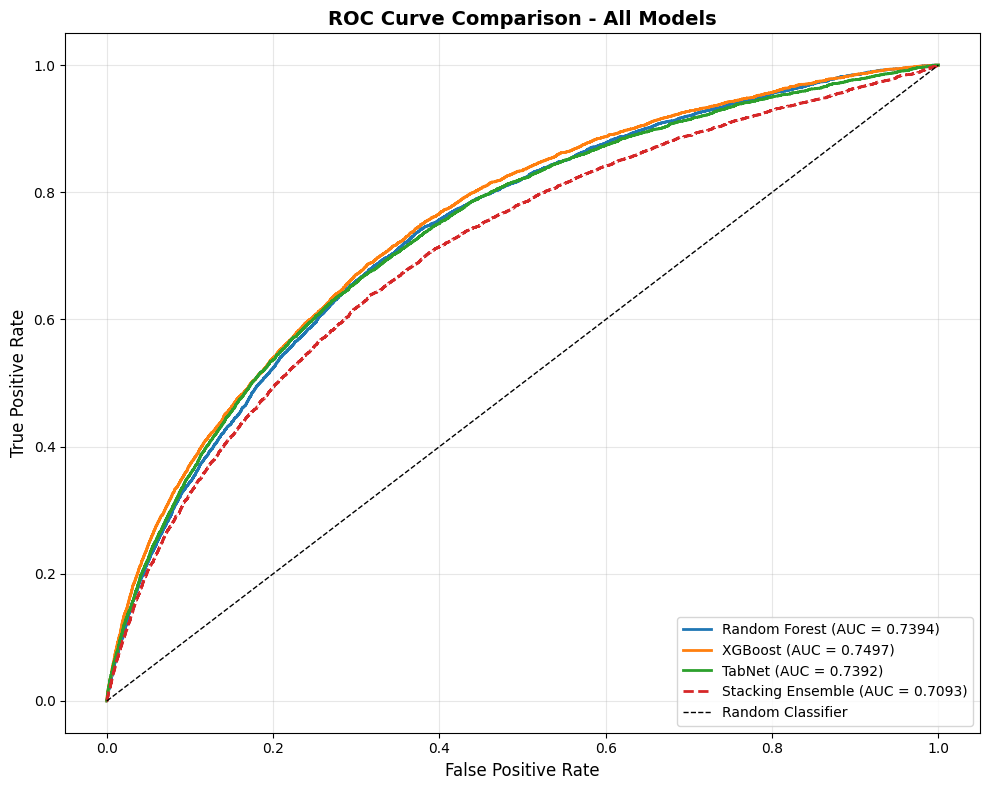

In [37]:
from sklearn.metrics import roc_curve

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_proba_rf):.4f})', linewidth=2)

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_pred_proba_xgb):.4f})', linewidth=2)

# TabNet
fpr_tabnet, tpr_tabnet, _ = roc_curve(y_test, y_pred_proba_tabnet)
plt.plot(fpr_tabnet, tpr_tabnet, label=f'TabNet (AUC = {roc_auc_score(y_test, y_pred_proba_tabnet):.4f})', linewidth=2)

# Stacking Ensemble
fpr_stack, tpr_stack, _ = roc_curve(y_test, y_pred_proba_stack)
plt.plot(fpr_stack, tpr_stack, label=f'Stacking Ensemble (AUC = {roc_auc_score(y_test, y_pred_proba_stack):.4f})', linewidth=2, linestyle='--')

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison - All Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 12. Visualization - Metrics Comparison Bar Chart

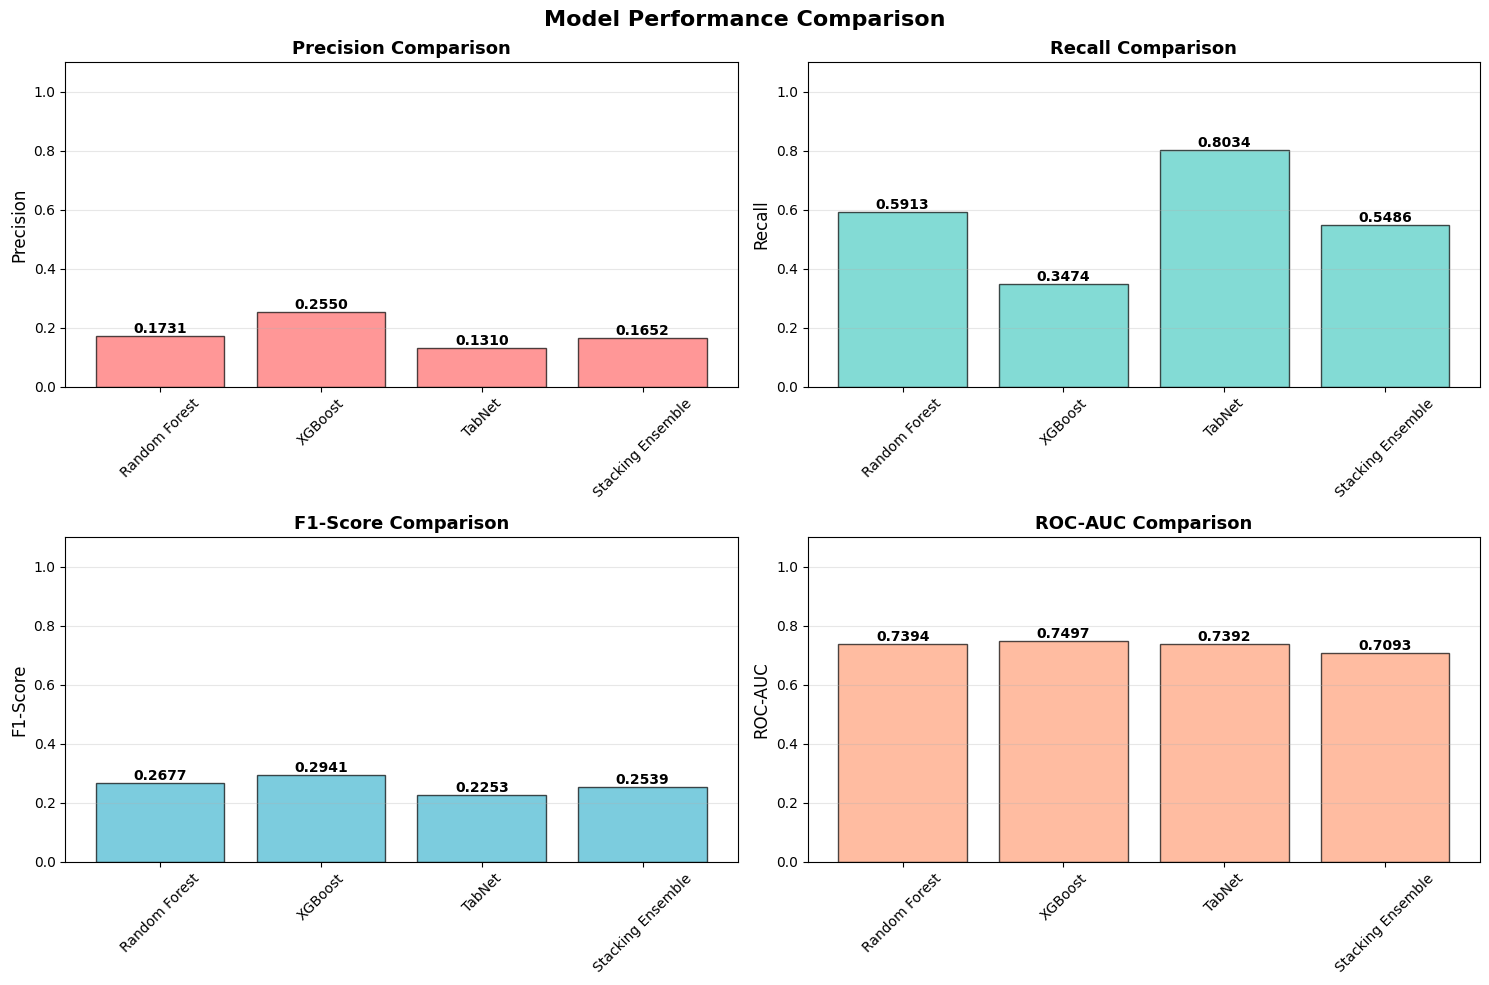

In [38]:
# Bar chart comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(results_df['Model'], results_df[metric], color=colors[idx], alpha=0.7, edgecolor='black')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.set_ylim([0, 1.1])
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 13. Feature Importance Analysis (Random Forest & XGBoost)

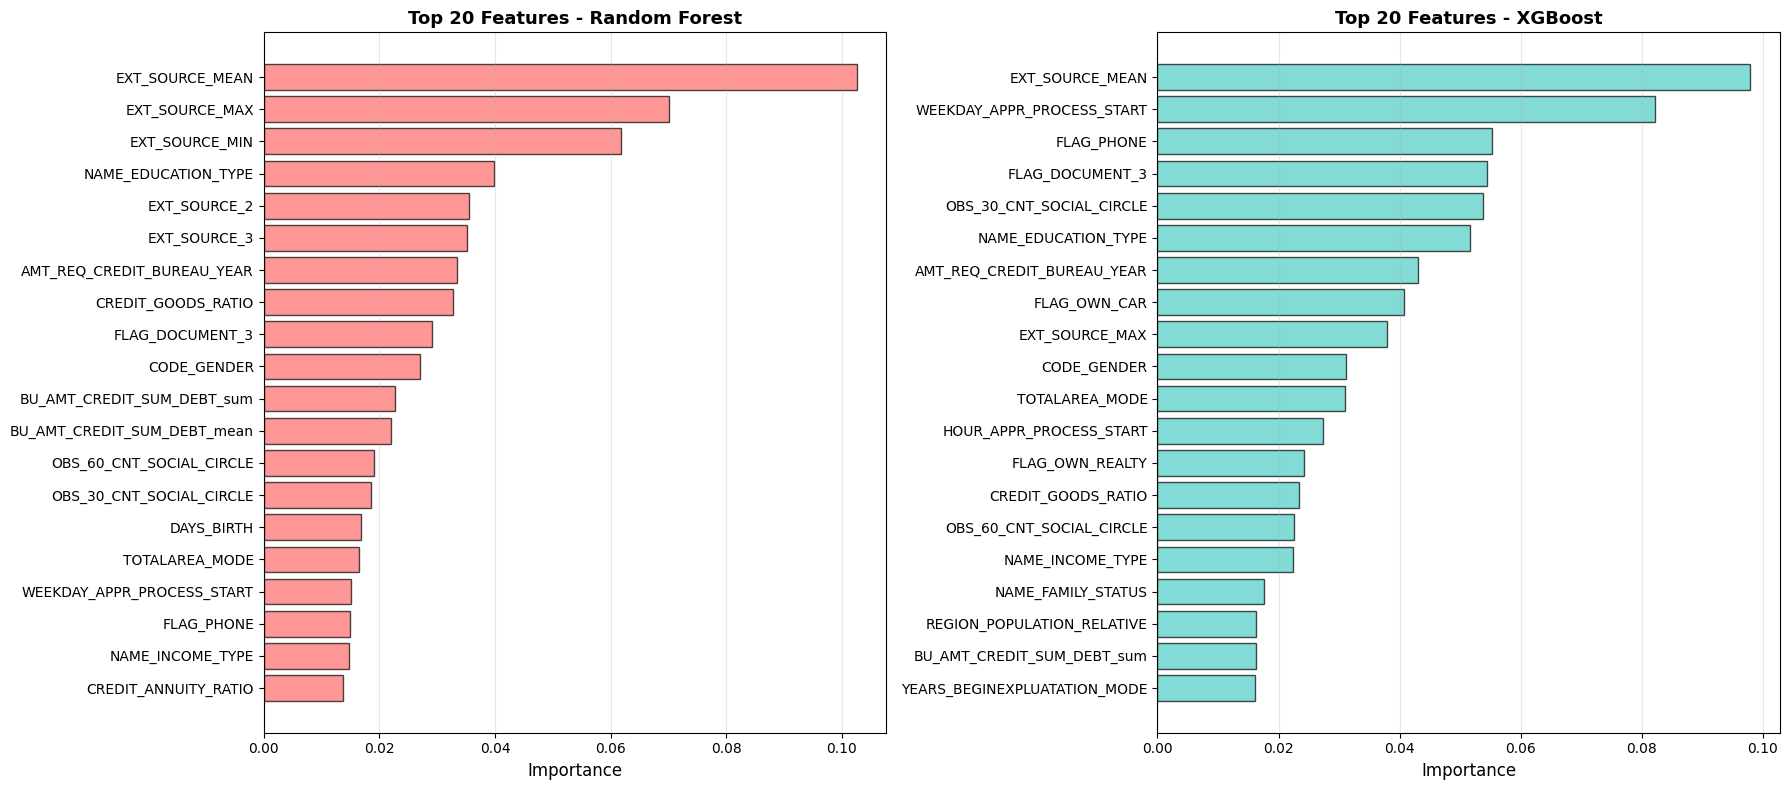

Top 10 Most Important Features (Random Forest):
                        Feature  Importance
152             EXT_SOURCE_MEAN    0.102540
153              EXT_SOURCE_MAX    0.070026
154              EXT_SOURCE_MIN    0.061824
11          NAME_EDUCATION_TYPE    0.039762
40                 EXT_SOURCE_2    0.035504
41                 EXT_SOURCE_3    0.035071
119  AMT_REQ_CREDIT_BUREAU_YEAR    0.033449
150          CREDIT_GOODS_RATIO    0.032669
95              FLAG_DOCUMENT_3    0.029188
1                   CODE_GENDER    0.026982

Top 10 Most Important Features (XGBoost):
                        Feature  Importance
152             EXT_SOURCE_MEAN    0.097942
30   WEEKDAY_APPR_PROCESS_START    0.082230
24                   FLAG_PHONE    0.055277
95              FLAG_DOCUMENT_3    0.054466
89     OBS_30_CNT_SOCIAL_CIRCLE    0.053853
11          NAME_EDUCATION_TYPE    0.051555
119  AMT_REQ_CREDIT_BUREAU_YEAR    0.042960
2                  FLAG_OWN_CAR    0.040679
153              EXT_SOURCE_M

In [39]:
# Get feature importances
feature_names = X_train.columns

# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

# XGBoost Feature Importance
xgb_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

# Plot feature importance
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Random Forest
axes[0].barh(range(len(rf_importance)), rf_importance['Importance'], color='#FF6B6B', alpha=0.7, edgecolor='black')
axes[0].set_yticks(range(len(rf_importance)))
axes[0].set_yticklabels(rf_importance['Feature'])
axes[0].set_xlabel('Importance', fontsize=12)
axes[0].set_title('Top 20 Features - Random Forest', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# XGBoost
axes[1].barh(range(len(xgb_importance)), xgb_importance['Importance'], color='#4ECDC4', alpha=0.7, edgecolor='black')
axes[1].set_yticks(range(len(xgb_importance)))
axes[1].set_yticklabels(xgb_importance['Feature'])
axes[1].set_xlabel('Importance', fontsize=12)
axes[1].set_title('Top 20 Features - XGBoost', fontsize=13, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("Top 10 Most Important Features (Random Forest):")
print(rf_importance.head(10))
print("\nTop 10 Most Important Features (XGBoost):")
print(xgb_importance.head(10))

## 14. Save Models & Results

In [42]:
import pickle
import os

# Create directory for models if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Save Random Forest
with open('models/random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

# Save XGBoost
with open('models/xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

# Save TabNet
tabnet_model.save_model('models/tabnet_model')

# Save Scaler
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save Meta-model
with open('models/meta_model.pkl', 'wb') as f:
    pickle.dump(meta_model, f)

# Save results to CSV
results_df.to_csv('models/model_comparison_results.csv', index=False)
print("Results saved to 'models/model_comparison_results.csv'")

# Save feature importance
rf_importance.to_csv('models/rf_feature_importance.csv', index=False)
xgb_importance.to_csv('models/xgb_feature_importance.csv', index=False)

Successfully saved model at models/tabnet_model.zip
Results saved to 'models/model_comparison_results.csv'
